# Billboard Dataset Exploration
## Focus: Understanding Lyrics & Musical Characteristics

24 years of Billboard Top 100 songs (2000-2023) with lyrics and Spotify audio features

In [1]:
library(tidyverse)
library(ggplot2)
library(tidytext)
library(gridExtra)
library(stringr)

# Diagnostic: Show current working directory
cat("Current working directory:", getwd(), "\n\n")

# Check if file exists at expected location
if (file.exists("../data/billboard_24years_lyrics_spotify.csv")) {
  cat("✓ File found at: ../data/billboard_24years_lyrics_spotify.csv\n")
  df <- read.csv("../data/billboard_24years_lyrics_spotify.csv", stringsAsFactors = FALSE)
} else {
  cat("✗ File NOT found at: ../data/billboard_24years_lyrics_spotify.csv\n")
  cat("\nChecking alternative locations...\n")
  
  # Try from project root
  if (file.exists("data/billboard_24years_lyrics_spotify.csv")) {
    cat("✓ File found at: data/billboard_24years_lyrics_spotify.csv\n")
    df <- read.csv("data/billboard_24years_lyrics_spotify.csv", stringsAsFactors = FALSE)
  } else {
    stop("Cannot find data file. Please check your working directory.")
  }
}

cat("\nTotal songs:", nrow(df), "\n")
cat("Years:", min(df$year), "-", max(df$year), "\n")

head(df %>% select(song, band_singer, year, ranking))

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.1     v stringr   1.6.0
v ggplot2   4.0.0     v tibble    3.3.0
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.1.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




Current working directory: /Users/lorenzogarduno/Documents/datasci:vis/exploration 

<U+2713> File found at: ../data/billboard_24years_lyrics_spotify.csv

Total songs: 3397 
Years: 2000 - 2023 


,song,band_singer,year,ranking
,<chr>,<chr>,<int>,<int>
1,Breathe,Faith Hill,2000,1
2,Smooth,Santana,2000,2
3,Smooth,Rob Thomas,2000,2
4,Maria Maria,Santana,2000,3
5,Maria Maria,The Product G&B,2000,3
6,I Wanna Know,Joe,2000,4


---
## Part 1: Dataset Overview


Average songs per year: 141.5417

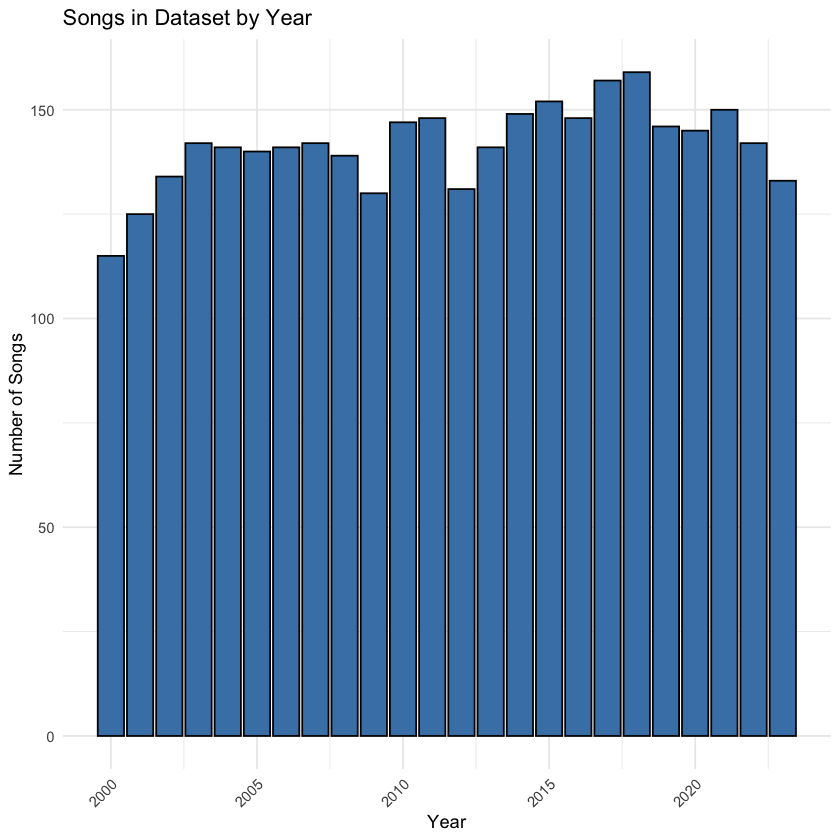

In [2]:
# Songs per year
songs_per_year <- df %>% count(year)

ggplot(songs_per_year, aes(x = year, y = n)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(title = "Songs in Dataset by Year",
       x = "Year", y = "Number of Songs") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

cat("\nAverage songs per year:", mean(songs_per_year$n))

In [3]:
cat("Songs with lyrics:", sum(!is.na(df$lyrics) & df$lyrics != ""), 
    "(", round(sum(!is.na(df$lyrics) & df$lyrics != "") / nrow(df) * 100, 1), "%)\n")

cat("Songs with Spotify features:", sum(!is.na(df$danceability)), 
    "(", round(sum(!is.na(df$danceability)) / nrow(df) * 100, 1), "%)\n")

Songs with lyrics: 3397 ( 100 %)
Songs with Spotify features: 486 ( 14.3 %)


---
## Part 2: Lyrical Analysis

### 2.1 Word Frequency

Total words: 589945 
Unique words: 27258 

    word     n
1   yeah 16674
2   love  9441
3   baby  8723
4    ooh  7153
5  wanna  6104
6   girl  5784
7    hey  4754
8   time  4021
9   feel  3177
10  life  2909
11 night  2869
12  shit  2821
13 bitch  2705
14 gonna  2597
15 nigga  2557
16  fuck  2541
17   gon  2493
18   ayy  2332
19 gotta  2320
20   boy  2251


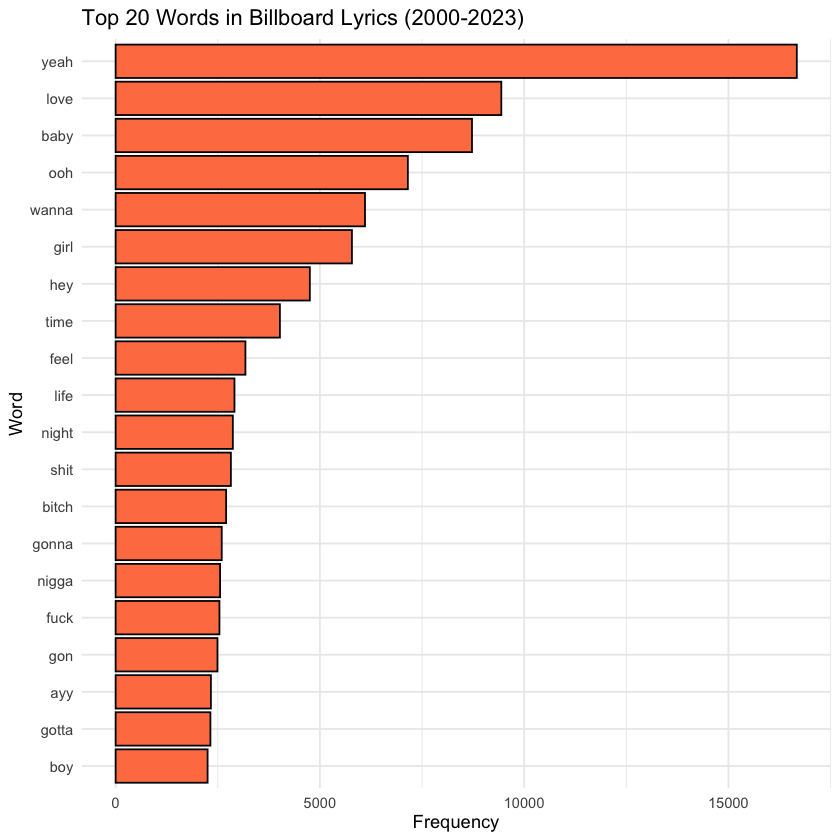

In [4]:
words_df <- df %>%
  select(year, ranking, lyrics) %>%
  filter(!is.na(lyrics) & lyrics != "") %>%
  unnest_tokens(word, lyrics) %>%
  filter(!word %in% stop_words$word) %>%
  filter(nchar(word) > 2)

word_counts <- words_df %>%
  count(word, sort = TRUE)

cat("Total words:", nrow(words_df), "\n")
cat("Unique words:", nrow(word_counts), "\n\n")

print(head(word_counts, 20))

ggplot(head(word_counts, 20), aes(x = reorder(word, n), y = n)) +
  geom_bar(stat = "identity", fill = "coral", color = "black") +
  coord_flip() +
  labs(title = "Top 20 Words in Billboard Lyrics (2000-2023)",
       x = "Word", y = "Frequency") +
  theme_minimal()

### 2.2 Lexical Complexity

In [5]:
calculate_lyrics_metrics <- function(lyrics_text) {
  words <- lyrics_text %>%
    str_to_lower() %>%
    str_replace_all("[^a-z\\s]", "") %>%
    str_split("\\s+") %>%
    unlist()
  
  words <- words[words != ""]
  total_words <- length(words)
  unique_words <- length(unique(words))
  
  if (total_words > 0) {
    data.frame(
      total_words = total_words,
      unique_words = unique_words,
      lexical_diversity = unique_words / total_words,
      repetition_rate = 1 - (unique_words / total_words),
      avg_word_length = mean(nchar(words))
    )
  } else {
    data.frame(total_words = 0, unique_words = 0, lexical_diversity = NA,
               repetition_rate = NA, avg_word_length = NA)
  }
}

df_with_lyrics <- df %>%
  filter(!is.na(lyrics) & lyrics != "") %>%
  select(song, band_singer, year, ranking, lyrics)

metrics_list <- lapply(df_with_lyrics$lyrics, calculate_lyrics_metrics)
metrics_df <- do.call(rbind, metrics_list)

lyrics_metrics <- cbind(
  df_with_lyrics %>% select(-lyrics),
  metrics_df
)

summary_table <- lyrics_metrics %>%
  summarise(
    `Avg Total Words` = round(mean(total_words, na.rm = TRUE), 0),
    `Avg Unique Words` = round(mean(unique_words, na.rm = TRUE), 0),
    `Avg Lexical Diversity` = round(mean(lexical_diversity, na.rm = TRUE), 3),
    `Avg Repetition Rate` = round(mean(repetition_rate, na.rm = TRUE), 3),
    `Avg Word Length` = round(mean(avg_word_length, na.rm = TRUE), 2)
  )

print(summary_table)

  Avg Total Words Avg Unique Words Avg Lexical Diversity Avg Repetition Rate
1             509              160                 0.323               0.677
  Avg Word Length
1            3.77


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


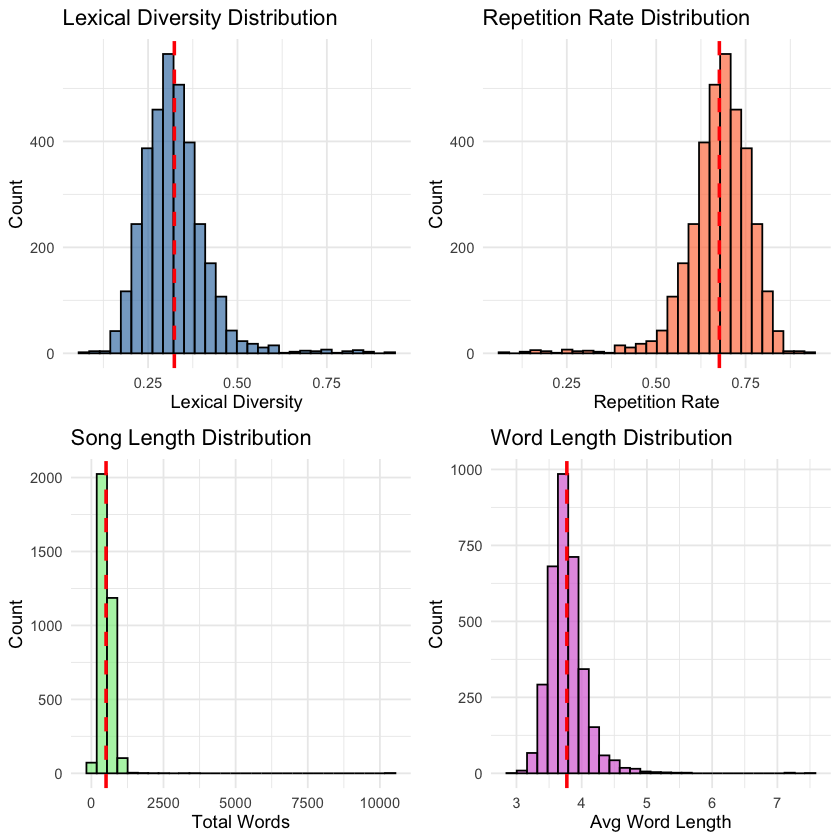

In [6]:
p1 <- ggplot(lyrics_metrics, aes(x = lexical_diversity)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(lexical_diversity, na.rm = TRUE)), 
             color = "red", linetype = "dashed", size = 1) +
  labs(title = "Lexical Diversity Distribution",
       x = "Lexical Diversity", y = "Count") +
  theme_minimal()

p2 <- ggplot(lyrics_metrics, aes(x = repetition_rate)) +
  geom_histogram(bins = 30, fill = "coral", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(repetition_rate, na.rm = TRUE)), 
             color = "red", linetype = "dashed", size = 1) +
  labs(title = "Repetition Rate Distribution",
       x = "Repetition Rate", y = "Count") +
  theme_minimal()

p3 <- ggplot(lyrics_metrics, aes(x = total_words)) +
  geom_histogram(bins = 30, fill = "lightgreen", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(total_words, na.rm = TRUE)), 
             color = "red", linetype = "dashed", size = 1) +
  labs(title = "Song Length Distribution",
       x = "Total Words", y = "Count") +
  theme_minimal()

p4 <- ggplot(lyrics_metrics, aes(x = avg_word_length)) +
  geom_histogram(bins = 30, fill = "orchid", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(avg_word_length, na.rm = TRUE)), 
             color = "red", linetype = "dashed", size = 1) +
  labs(title = "Word Length Distribution",
       x = "Avg Word Length", y = "Count") +
  theme_minimal()

grid.arrange(p1, p2, p3, p4, ncol = 2)

In [7]:
# Define common function words
function_words <- c(
  "i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them",
  "my", "your", "his", "its", "our", "their", "mine", "yours", "hers", "ours", "theirs",
  "myself", "yourself", "himself", "herself", "itself", "ourselves", "themselves",
  "this", "that", "these", "those", "who", "what", "which", "whom", "whose",
  "a", "an", "the",
  "in", "on", "at", "by", "for", "with", "about", "against", "between", "into",
  "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
  "of", "off", "over", "under", "out", "around", "along",
  "and", "but", "or", "nor", "so", "yet", "for", "because", "although", "though",
  "if", "unless", "since", "while", "as", "when", "where", "than",
  "is", "am", "are", "was", "were", "be", "been", "being",
  "have", "has", "had", "having",
  "do", "does", "did", "doing",
  "will", "would", "shall", "should", "may", "might", "must", "can", "could",
  "not", "no", "yes", "very", "too", "so", "just", "really", "quite",
  "there", "here", "now", "then", "all", "some", "any", "both", "each", "every"
)

calculate_lexical_density <- function(lyrics_text) {
  words <- lyrics_text %>%
    str_to_lower() %>%
    str_replace_all("[^a-z\\s]", "") %>%
    str_split("\\s+") %>%
    unlist()
  
  words <- words[words != ""]
  total_words <- length(words)
  
  if (total_words > 0) {
    content_words <- sum(!words %in% function_words)
    lexical_density <- content_words / total_words
    
    data.frame(
      lexical_density = lexical_density,
      content_words = content_words,
      function_words = total_words - content_words
    )
  } else {
    data.frame(lexical_density = NA, content_words = 0, function_words = 0)
  }
}

# Calculate lexical density for all songs
density_list <- lapply(df_with_lyrics$lyrics, calculate_lexical_density)
density_df <- do.call(rbind, density_list)

# Add to existing metrics
lyrics_metrics <- cbind(lyrics_metrics, density_df)

cat("✓ Lexical density calculated and added to lyrics_metrics\n")

<U+2713> Lexical density calculated and added to lyrics_metrics


Overall Lexical Density:


  Avg Lexical Density Median Lexical Density Avg Content Words
1               0.557                  0.546               284
  Avg Function Words
1                224


`geom_smooth()` using formula = 'y ~ x'



Correlation: r = 0.314 , p = 0 


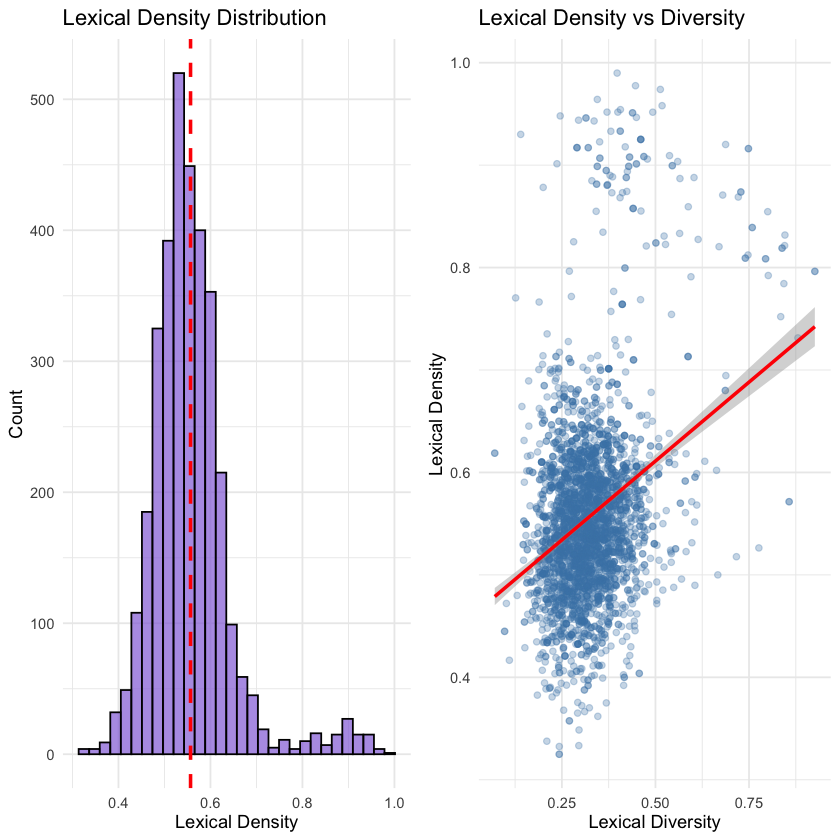

In [8]:
# Overall lexical density statistics
density_summary <- lyrics_metrics %>%
  summarise(
    `Avg Lexical Density` = round(mean(lexical_density, na.rm = TRUE), 3),
    `Median Lexical Density` = round(median(lexical_density, na.rm = TRUE), 3),
    `Avg Content Words` = round(mean(content_words, na.rm = TRUE), 0),
    `Avg Function Words` = round(mean(function_words, na.rm = TRUE), 0)
  )

cat("Overall Lexical Density:\n")
print(density_summary)

# Visualize distribution
p1 <- ggplot(lyrics_metrics, aes(x = lexical_density)) +
  geom_histogram(bins = 30, fill = "mediumpurple", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(lexical_density, na.rm = TRUE)), 
             color = "red", linetype = "dashed", size = 1) +
  labs(title = "Lexical Density Distribution",
       x = "Lexical Density", y = "Count") +
  theme_minimal()

p2 <- ggplot(lyrics_metrics, aes(x = lexical_diversity, y = lexical_density)) +
  geom_point(alpha = 0.3, color = "steelblue") +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(title = "Lexical Density vs Diversity",
       x = "Lexical Diversity", y = "Lexical Density") +
  theme_minimal()

grid.arrange(p1, p2, ncol = 2)

cor_test <- cor.test(lyrics_metrics$lexical_density, lyrics_metrics$lexical_diversity)
cat("\nCorrelation: r =", round(cor_test$estimate, 3), ", p =", round(cor_test$p.value, 4), "\n")

In [9]:
# Lexical density by year
yearly_density <- lyrics_metrics %>%
  group_by(year) %>%
  summarise(
    avg_density = mean(lexical_density, na.rm = TRUE),
    median_density = median(lexical_density, na.rm = TRUE),
    sd_density = sd(lexical_density, na.rm = TRUE),
    num_songs = n()
  ) %>%
  arrange(desc(avg_density)) %>%
  mutate(rank = row_number())

cat("Lexical Density by Year (Ranked):\n")
print(yearly_density %>%
  mutate(
    avg_density = round(avg_density, 3),
    median_density = round(median_density, 3),
    sd_density = round(sd_density, 3)
  ), n = Inf)

top_density_year <- yearly_density[1, ]
bottom_density_year <- yearly_density[nrow(yearly_density), ]

cat("\nHighest density:", top_density_year$year, "-", round(top_density_year$avg_density, 3), "\n")
cat("Lowest density:", bottom_density_year$year, "-", round(bottom_density_year$avg_density, 3), "\n")

Lexical Density by Year (Ranked):
# A tibble: 24 x 6
    year avg_density median_density sd_density num_songs  rank
   <int>       <dbl>          <dbl>      <dbl>     <int> <int>
 1  2023       0.596          0.55       0.139       133     1
 2  2018       0.583          0.563      0.114       159     2
 3  2021       0.579          0.566      0.094       150     3
 4  2022       0.578          0.545      0.13        142     4
 5  2019       0.578          0.568      0.093       146     5
 6  2017       0.564          0.56       0.096       157     6
 7  2010       0.563          0.557      0.07        147     7
 8  2012       0.561          0.556      0.085       131     8
 9  2020       0.56           0.555      0.075       145     9
10  2014       0.559          0.553      0.087       149    10
11  2013       0.555          0.557      0.083       141    11
12  2016       0.554          0.549      0.068       148    12
13  2009       0.553          0.542      0.064       130    13
14

`geom_smooth()` using formula = 'y ~ x'



Temporal trend: r = 0.882 , p = 0 


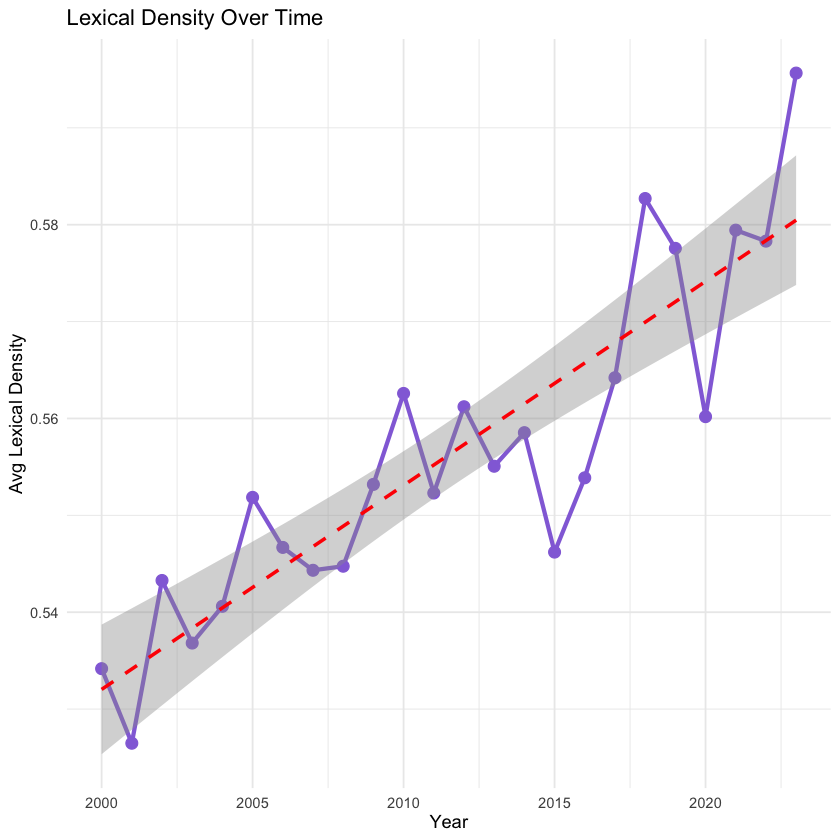

In [10]:
# Visualize lexical density trends over time
yearly_density_ordered <- yearly_density %>% arrange(year)

p1 <- ggplot(yearly_density_ordered, aes(x = year, y = avg_density)) +
  geom_line(color = "mediumpurple", size = 1.2) +
  geom_point(size = 3, color = "mediumpurple") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(title = "Lexical Density Over Time",
       x = "Year", y = "Avg Lexical Density") +
  theme_minimal()

print(p1)

cor_density_time <- cor.test(yearly_density_ordered$year, yearly_density_ordered$avg_density)
cat("\nTemporal trend: r =", round(cor_density_time$estimate, 3), ", p =", round(cor_density_time$p.value, 4), "\n")

In [11]:
# Extreme examples
highest_density <- lyrics_metrics %>%
  arrange(desc(lexical_density)) %>%
  select(song, band_singer, year, ranking, lexical_density, lexical_diversity) %>%
  head(10)

lowest_density <- lyrics_metrics %>%
  arrange(lexical_density) %>%
  select(song, band_singer, year, ranking, lexical_density, lexical_diversity) %>%
  head(10)

cat("Highest Lexical Density Songs:\n")
print(highest_density)

cat("\n\nLowest Lexical Density Songs:\n")
print(lowest_density)

Highest Lexical Density Songs:
                         song   band_singer year ranking lexical_density
1               Thugz Mansion          2Pac 2003      80       0.9898580
2                        E.T.    Kanye West 2011       4       0.9775216
3                         Bad       Rihanna 2013      59       0.9739130
4                        Dura  Daddy Yankee 2018      93       0.9641434
5              Te Bot\303\251     Bad Bunny 2018      81       0.9580247
6              La Beb\303\251    Peso Pluma 2023      40       0.9541833
7  Despu\303\251s de la Playa     Bad Bunny 2022      78       0.9517544
8                       Seven         Latto 2023      82       0.9517426
9                     Hot Boy Bobby Shmurda 2014      54       0.9516908
10                      Party     Bad Bunny 2022      77       0.9510358
   lexical_diversity
1          0.3975659
2          0.4466859
3          0.5130435
4          0.3446215
5          0.5176955
6          0.4063745
7          0.370614

In [12]:
# (This cell previously contained lexical density calculation - now moved to cell 10)
# Keeping as placeholder for section continuity

In [13]:
# (This markdown header moved earlier in notebook)

In [14]:
# Removed duplicate lexical density calculation (now in cell 10)

# Removed duplicate markdown header

### 2.3 Lyrics vs Chart Performance

# A tibble: 20 x 6
   rank_group Lexical_Diversity Repetition_Rate Avg_Word_Length Avg_Total_Words
   <chr>                  <dbl>           <dbl>           <dbl>           <dbl>
 1 1-5                    0.323           0.677            3.8              484
 2 6-10                   0.311           0.689            3.76             560
 3 11-15                  0.318           0.682            3.82             541
 4 16-20                  0.313           0.687            3.78             532
 5 21-25                  0.324           0.676            3.78             515
 6 26-30                  0.313           0.687            3.74             496
 7 31-35                  0.323           0.677            3.75             495
 8 36-40                  0.311           0.689            3.76             515
 9 41-45                  0.324           0.676            3.76             527
10 46-50                  0.32            0.68             3.76             498
11 51-55             

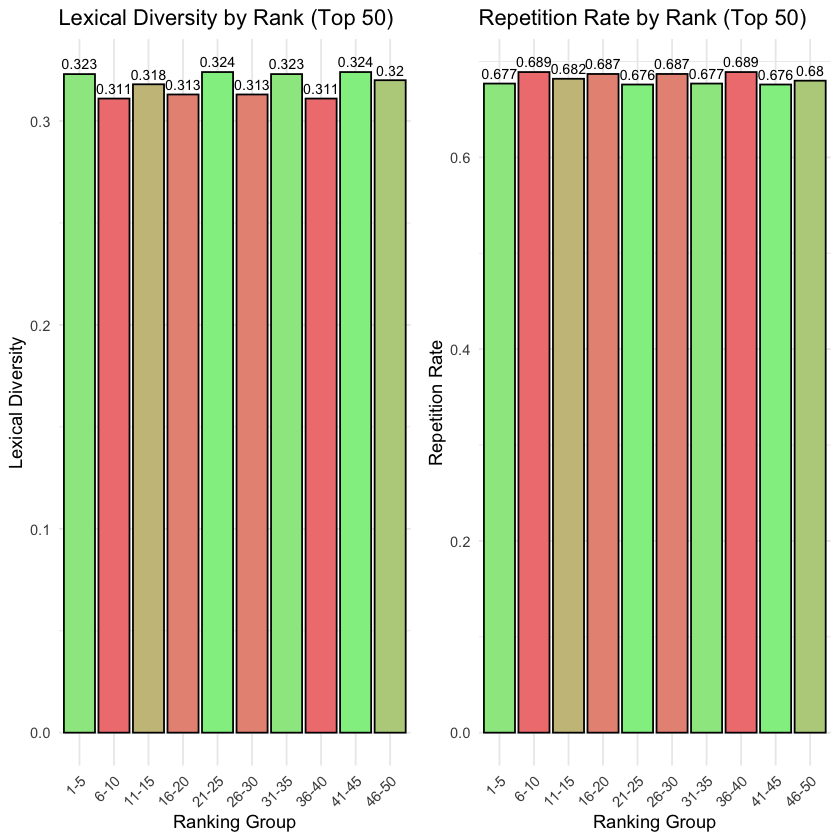

In [15]:
lyrics_by_rank <- lyrics_metrics %>%
  mutate(
    group_num = ceiling(ranking / 5),
    rank_group = paste0((group_num - 1) * 5 + 1, "-", group_num * 5)
  )

rank_summary <- lyrics_by_rank %>%
  group_by(rank_group, group_num) %>%
  summarise(
    Lexical_Diversity = round(mean(lexical_diversity, na.rm = TRUE), 3),
    Repetition_Rate = round(mean(repetition_rate, na.rm = TRUE), 3),
    Avg_Word_Length = round(mean(avg_word_length, na.rm = TRUE), 2),
    Avg_Total_Words = round(mean(total_words, na.rm = TRUE), 0),
    Count = n(),
    .groups = "drop"
  ) %>%
  arrange(group_num)

print(rank_summary %>% select(-group_num))

rank_summary_subset <- rank_summary %>% head(10)

p1 <- ggplot(rank_summary_subset, aes(x = reorder(rank_group, group_num), y = Lexical_Diversity, fill = Lexical_Diversity)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = Lexical_Diversity), vjust = -0.5, size = 3) +
  scale_fill_gradient(low = "lightcoral", high = "lightgreen") +
  labs(title = "Lexical Diversity by Rank (Top 50)",
       x = "Ranking Group", y = "Lexical Diversity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none")

p2 <- ggplot(rank_summary_subset, aes(x = reorder(rank_group, group_num), y = Repetition_Rate, fill = Repetition_Rate)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = Repetition_Rate), vjust = -0.5, size = 3) +
  scale_fill_gradient(low = "lightgreen", high = "lightcoral") +
  labs(title = "Repetition Rate by Rank (Top 50)",
       x = "Ranking Group", y = "Repetition Rate") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none")

grid.arrange(p1, p2, ncol = 2)

In [16]:
top_group <- lyrics_by_rank %>% filter(rank_group == "1-5")
bottom_groups <- lyrics_by_rank %>% filter(group_num >= 17)

lex_test <- t.test(top_group$lexical_diversity, bottom_groups$lexical_diversity)
cat("Top 5 vs Bottom 20 - Lexical Diversity:\n")
cat("  Top:", round(mean(top_group$lexical_diversity, na.rm = TRUE), 4), "\n")
cat("  Bottom:", round(mean(bottom_groups$lexical_diversity, na.rm = TRUE), 4), "\n")
cat("  p-value:", round(lex_test$p.value, 4), "\n\n")

rep_test <- t.test(top_group$repetition_rate, bottom_groups$repetition_rate)
cat("Top 5 vs Bottom 20 - Repetition Rate:\n")
cat("  Top:", round(mean(top_group$repetition_rate, na.rm = TRUE), 4), "\n")
cat("  Bottom:", round(mean(bottom_groups$repetition_rate, na.rm = TRUE), 4), "\n")
cat("  p-value:", round(rep_test$p.value, 4), "\n")

Top 5 vs Bottom 20 - Lexical Diversity:
  Top: 0.3228 
  Bottom: 0.3352 
  p-value: 0.1213 

Top 5 vs Bottom 20 - Repetition Rate:
  Top: 0.6772 
  Bottom: 0.6648 
  p-value: 0.1213 


### 2.4 Temporal Trends

VALIDATING RANKING COMPLETENESS (1-100) FOR EACH YEAR

Years with COMPLETE data (all rankings 1-100): 17 
Years with MISSING rankings: 7 

MISSING RANKINGS BY YEAR:

Year 2002 : Missing 1 rankings
  Ranks: 88 

Year 2003 : Missing 1 rankings
  Ranks: 82 

Year 2006 : Missing 1 rankings
  Ranks: 7 

Year 2011 : Missing 1 rankings
  Ranks: 19 

Year 2013 : Missing 1 rankings
  Ranks: 21 

Year 2020 : Missing 1 rankings
  Ranks: 94 

Year 2023 : Missing 1 rankings
  Ranks: 5 


TOTAL MISSING RANKINGS ACROSS ALL YEARS: 7 



CORRECTED DISTINCT SONGS PER YEAR:
# A tibble: 24 x 4
    year distinct_songs expected_songs missing_songs
   <int>          <int>          <dbl>         <dbl>
 1  2000            100            100             0
 2  2001            100            100             0
 3  2002             99            100             1
 4  2003             99            100             1
 5  2004            100            100             0
 6  2005            100            100          

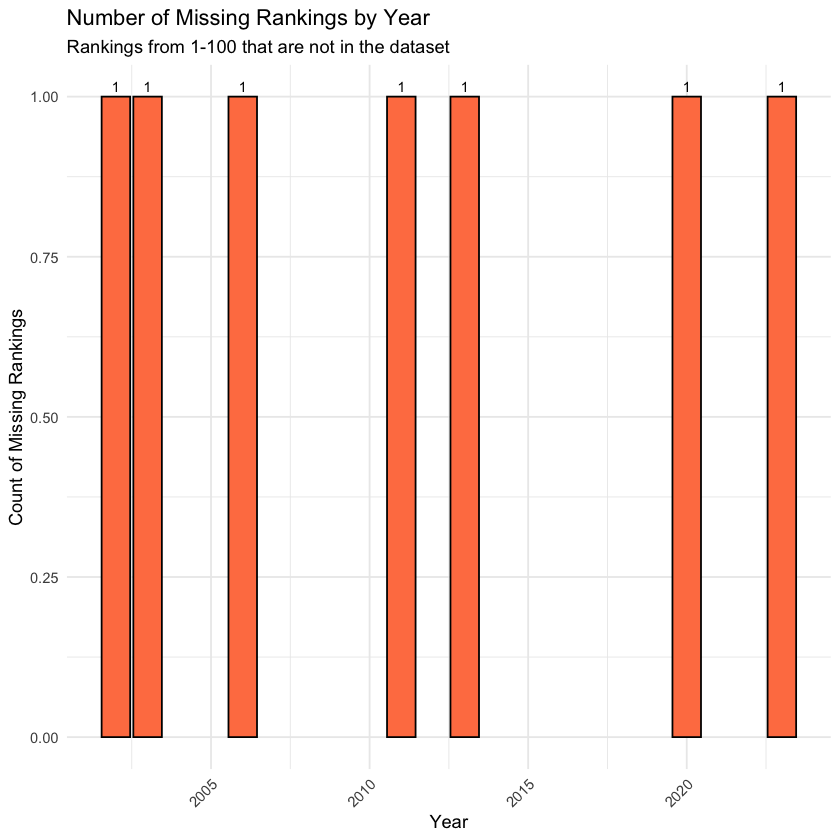

In [17]:
# VALIDATE: Check for missing rankings (1-100) in each year
cat("VALIDATING RANKING COMPLETENESS (1-100) FOR EACH YEAR\n")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n\n")

# Get all distinct song-year-ranking combinations (remove duplicate collaborators)
distinct_rankings <- df %>%
  group_by(year, song, ranking) %>%
  slice(1) %>%
  ungroup() %>%
  select(year, ranking, song, band_singer)

# Check each year for missing rankings
all_years <- sort(unique(df$year))
missing_rankings_list <- list()

for (yr in all_years) {
  year_data <- distinct_rankings %>% filter(year == yr)
  present_rankings <- sort(unique(year_data$ranking))
  expected_rankings <- 1:100
  missing_rankings <- setdiff(expected_rankings, present_rankings)
  
  if (length(missing_rankings) > 0) {
    missing_rankings_list[[as.character(yr)]] <- missing_rankings
  }
}

# Summary
cat("Years with COMPLETE data (all rankings 1-100):", 
    length(all_years) - length(missing_rankings_list), "\n")
cat("Years with MISSING rankings:", length(missing_rankings_list), "\n\n")

# Show missing rankings by year
if (length(missing_rankings_list) > 0) {
  cat("MISSING RANKINGS BY YEAR:\n")
  cat("=" %>% rep(70) %>% paste(collapse = ""), "\n\n")
  
  missing_df <- data.frame()
  
  for (yr in names(missing_rankings_list)) {
    missing <- missing_rankings_list[[yr]]
    cat("Year", yr, ": Missing", length(missing), "rankings\n")
    cat("  Ranks:", paste(missing, collapse = ", "), "\n\n")
    
    # Add to dataframe for later analysis
    for (rank in missing) {
      missing_df <- rbind(missing_df, data.frame(year = as.numeric(yr), missing_rank = rank))
    }
  }
  
  cat("\nTOTAL MISSING RANKINGS ACROSS ALL YEARS:", nrow(missing_df), "\n\n")
  
  # Visualize missing data
  if (nrow(missing_df) > 0) {
    missing_summary <- missing_df %>%
      count(year, name = "missing_count")
    
    ggplot(missing_summary, aes(x = year, y = missing_count)) +
      geom_bar(stat = "identity", fill = "coral", color = "black") +
      geom_text(aes(label = missing_count), vjust = -0.5, size = 3) +
      labs(title = "Number of Missing Rankings by Year",
           subtitle = "Rankings from 1-100 that are not in the dataset",
           x = "Year", 
           y = "Count of Missing Rankings") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
  }
  
} else {
  cat("✓ ALL YEARS HAVE COMPLETE DATA (rankings 1-100)\n")
}

# Now calculate CORRECTED distinct songs per year (accounting for missing data)
distinct_songs_per_year_corrected <- distinct_rankings %>%
  group_by(year) %>%
  summarise(
    distinct_songs = n(),
    expected_songs = 100,
    missing_songs = 100 - n(),
    .groups = "drop"
  )

cat("\n\nCORRECTED DISTINCT SONGS PER YEAR:\n")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n")
print(distinct_songs_per_year_corrected)

cat("\nSummary:\n")
cat("Years with exactly 100 songs:", sum(distinct_songs_per_year_corrected$distinct_songs == 100), "\n")
cat("Years with < 100 songs:", sum(distinct_songs_per_year_corrected$distinct_songs < 100), "\n")

In [18]:
# Deep dive into 2002 to understand duplicates
year_to_analyze <- 2002

songs_2002 <- df %>% filter(year == year_to_analyze)

cat("=== ANALYSIS FOR YEAR", year_to_analyze, "===\n")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n\n")

cat("Total rows in dataset:", nrow(songs_2002), "\n")
cat("Distinct songs:", n_distinct(songs_2002$song), "\n")
cat("Duplicate entries:", nrow(songs_2002) - n_distinct(songs_2002$song), "\n\n")

# Find songs with multiple entries (collaborators)
duplicated_songs <- songs_2002 %>%
  group_by(song) %>%
  summarise(count = n(), .groups = "drop") %>%
  filter(count > 1) %>%
  arrange(desc(count))

cat("SONGS WITH MULTIPLE ENTRIES (", nrow(duplicated_songs), " songs):\n", sep = "")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n")

if (nrow(duplicated_songs) > 0) {
  # Show details for each duplicated song
  for (i in 1:nrow(duplicated_songs)) {
    song_name <- duplicated_songs$song[i]
    song_count <- duplicated_songs$count[i]
    
    cat("\n", i, ". ", song_name, " (appears ", song_count, " times)\n", sep = "")
    
    # Show all artists for this song
    artists <- songs_2002 %>%
      filter(song == song_name) %>%
      select(band_singer, ranking)
    
    for (j in 1:nrow(artists)) {
      cat("   - ", artists$band_singer[j], " (rank: ", artists$ranking[j], ")\n", sep = "")
    }
  }
  
  cat("\n\nTOTAL EXTRA ROWS FROM DUPLICATES:", sum(duplicated_songs$count - 1), "\n")
} else {
  cat("No duplicate songs found!\n")
}

# Show all DISTINCT songs for reference
cat("\n\n")
cat("ALL DISTINCT SONGS IN", year_to_analyze, "(", n_distinct(songs_2002$song), " songs):\n", sep = " ")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n")

distinct_songs_list <- songs_2002 %>%
  group_by(song) %>%
  slice(1) %>%
  arrange(ranking) %>%
  select(ranking, song, band_singer)

print(distinct_songs_list, n = Inf)

=== ANALYSIS FOR YEAR 2002 ===

Total rows in dataset: 134 
Distinct songs: 98 
Duplicate entries: 36 

SONGS WITH MULTIPLE ENTRIES (25 songs):

1. Down 4 U (appears 4 times)
   - Ja Rule (rank: 44)
   - Ashanti (rank: 44)
   - Charli Baltimore (rank: 44)
   - Vita (rank: 44)

2. I Need a Girl (Part Two) (appears 4 times)
   - P. Diddy (rank: 18)
   - Ginuwine (rank: 18)
   - Loon (rank: 18)
   - Mario Winans (rank: 18)

3. Heaven (appears 3 times)
   - DJ Sammy (rank: 31)
   - Yanou (rank: 31)
   - Do (rank: 31)

4. Hero (appears 3 times)
   - Enrique Iglesias (rank: 22)
   - Chad Kroeger (rank: 25)
   - Josey Scott (rank: 25)

5. Hey Ma (appears 3 times)
   - Cam'ron (rank: 53)
   - Juelz Santana (rank: 53)
   - Freekey Zekey (rank: 53)

6. I Need a Girl (Part One) (appears 3 times)
   - P. Diddy (rank: 15)
   - Usher (rank: 15)
   - Loon (rank: 15)

7. If I Could Go! (appears 3 times)
   - Angie Martinez (rank: 69)
   - Lil' Mo (rank: 69)
   - Sacario (rank: 69)

8. Move Bitch (appe

In [19]:
# Look up specific rankings in 2002
year_lookup <- 2002
rankings_to_find <- c(25, 88)

cat("SONGS AT SPECIFIC RANKINGS IN", year_lookup, ":\n")
cat("=" %>% rep(70) %>% paste(collapse = ""), "\n\n")

for (rank in rankings_to_find) {
  songs_at_rank <- df %>%
    filter(year == year_lookup & ranking == rank) %>%
    select(ranking, song, band_singer, year)
  
  if (nrow(songs_at_rank) > 0) {
    cat("Rank #", rank, ":\n", sep = "")
    for (i in 1:nrow(songs_at_rank)) {
      cat("  - \"", songs_at_rank$song[i], "\" by ", songs_at_rank$band_singer[i], "\n", sep = "")
    }
    
    if (nrow(songs_at_rank) > 1) {
      cat("  (Note: Multiple entries for same song - likely collaborators)\n")
    }
    cat("\n")
  } else {
    cat("Rank #", rank, ": NOT FOUND in dataset\n\n", sep = "")
  }
}

SONGS AT SPECIFIC RANKINGS IN 2002 :

Rank #25:
  - "Hero" by Chad Kroeger
  - "Hero" by Josey Scott
  (Note: Multiple entries for same song - likely collaborators)

Rank #88: NOT FOUND in dataset



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



Lexical Diversity trend: r = 0.483 , p = 0.0168 
Repetition Rate trend: r = -0.483 , p = 0.0168 


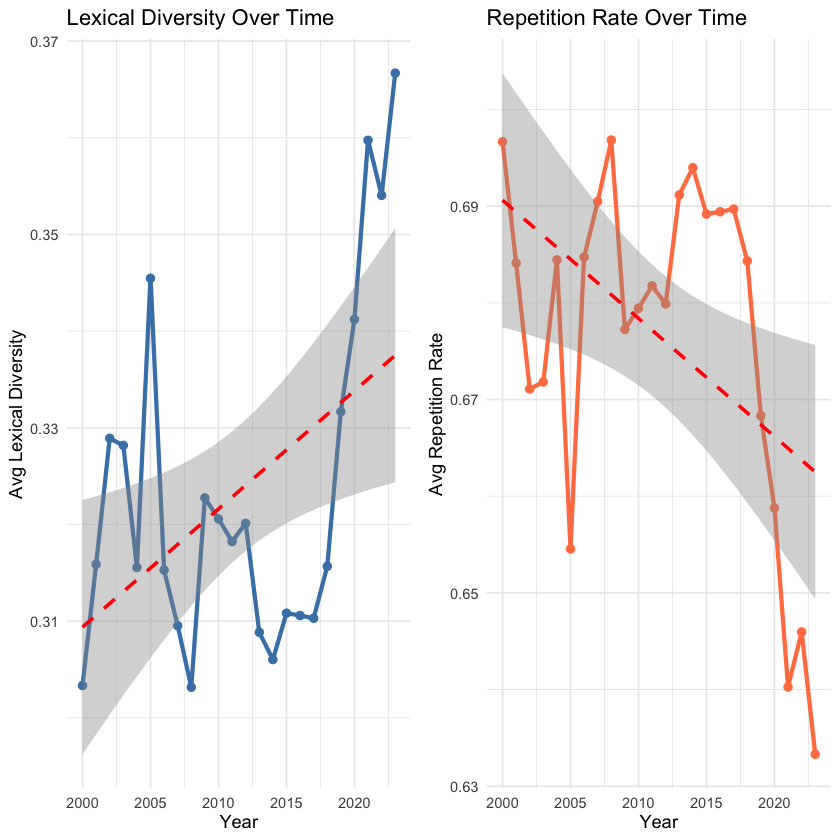

In [20]:
yearly_trends <- lyrics_metrics %>%
  group_by(year) %>%
  summarise(
    avg_diversity = mean(lexical_diversity, na.rm = TRUE),
    avg_repetition = mean(repetition_rate, na.rm = TRUE),
    avg_word_length = mean(avg_word_length, na.rm = TRUE),
    avg_total_words = mean(total_words, na.rm = TRUE)
  )

p1 <- ggplot(yearly_trends, aes(x = year, y = avg_diversity)) +
  geom_line(color = "steelblue", size = 1.2) +
  geom_point(size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(title = "Lexical Diversity Over Time",
       x = "Year", y = "Avg Lexical Diversity") +
  theme_minimal()

p2 <- ggplot(yearly_trends, aes(x = year, y = avg_repetition)) +
  geom_line(color = "coral", size = 1.2) +
  geom_point(size = 2, color = "coral") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(title = "Repetition Rate Over Time",
       x = "Year", y = "Avg Repetition Rate") +
  theme_minimal()

grid.arrange(p1, p2, ncol = 2)

cor_div <- cor.test(yearly_trends$year, yearly_trends$avg_diversity)
cor_rep <- cor.test(yearly_trends$year, yearly_trends$avg_repetition)

cat("\nLexical Diversity trend: r =", round(cor_div$estimate, 3), 
    ", p =", round(cor_div$p.value, 4), "\n")

cat("Repetition Rate trend: r =", round(cor_rep$estimate, 3), 
    ", p =", round(cor_rep$p.value, 4), "\n")

In [21]:
# Calculate yearly rankings by lexical diversity
yearly_rankings <- lyrics_metrics %>%
  group_by(year) %>%
  summarise(
    avg_lexical_diversity = mean(lexical_diversity, na.rm = TRUE),
    median_lexical_diversity = median(lexical_diversity, na.rm = TRUE),
    avg_repetition = mean(repetition_rate, na.rm = TRUE),
    avg_word_length = mean(avg_word_length, na.rm = TRUE),
    avg_total_words = mean(total_words, na.rm = TRUE),
    num_songs = n(),
    .groups = "drop"
  ) %>%
  arrange(desc(avg_lexical_diversity)) %>%
  mutate(
    rank = row_number(),
    decade = paste0(floor(year / 10) * 10, "s"),
    diversity_category = case_when(
      rank <= 6 ~ "Most Diverse (Top 25%)",
      rank <= 12 ~ "Above Average",
      rank <= 18 ~ "Below Average",
      TRUE ~ "Least Diverse (Bottom 25%)"
    )
  )

# Calculate year-over-year changes
yearly_rankings_ordered <- yearly_rankings %>%
  arrange(year) %>%
  mutate(
    yoy_change = avg_lexical_diversity - lag(avg_lexical_diversity),
    yoy_pct_change = (yoy_change / lag(avg_lexical_diversity)) * 100
  )

cat("✓ yearly_rankings and yearly_rankings_ordered created for use in visualizations\n")

<U+2713> yearly_rankings and yearly_rankings_ordered created for use in visualizations



Top 5 increases:
# A tibble: 5 x 3
  change_label yoy_change yoy_pct_change
  <chr>             <dbl>          <dbl>
1 2004 to 2005     0.0299           9.48
2 2008 to 2009     0.0196           6.46
3 2020 to 2021     0.0185           5.43
4 2018 to 2019     0.016            5.07
5 2001 to 2002     0.013            4.13

Top 5 decreases:
# A tibble: 5 x 3
  change_label yoy_change yoy_pct_change
  <chr>             <dbl>          <dbl>
1 2005 to 2006    -0.0302          -8.74
2 2003 to 2004    -0.0126          -3.85
3 2012 to 2013    -0.0113          -3.52
4 2007 to 2008    -0.0064          -2.06
5 2006 to 2007    -0.0058          -1.82


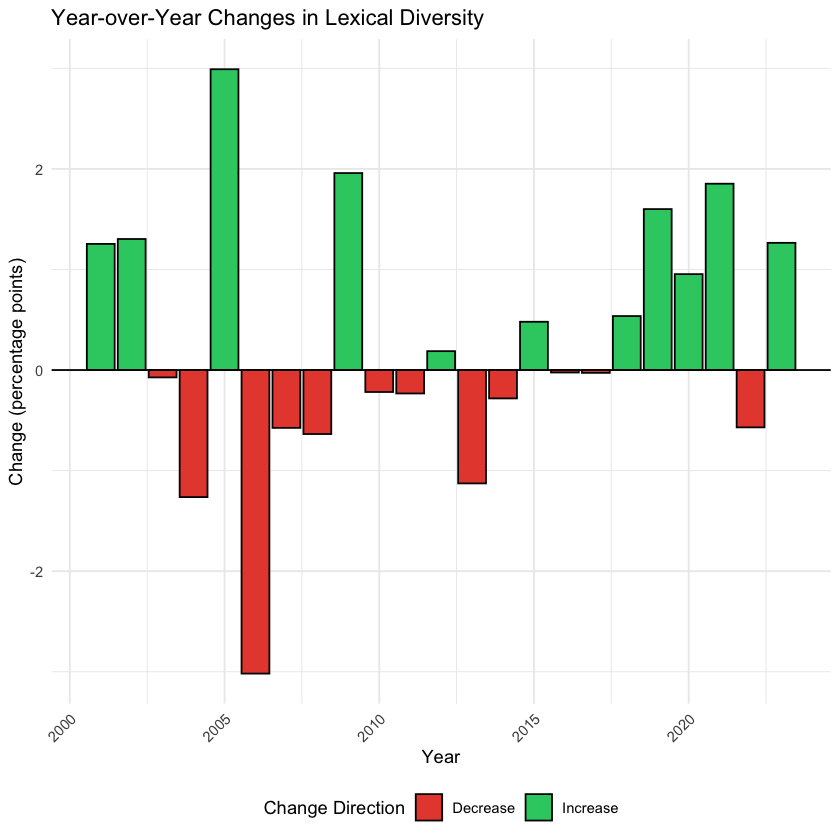

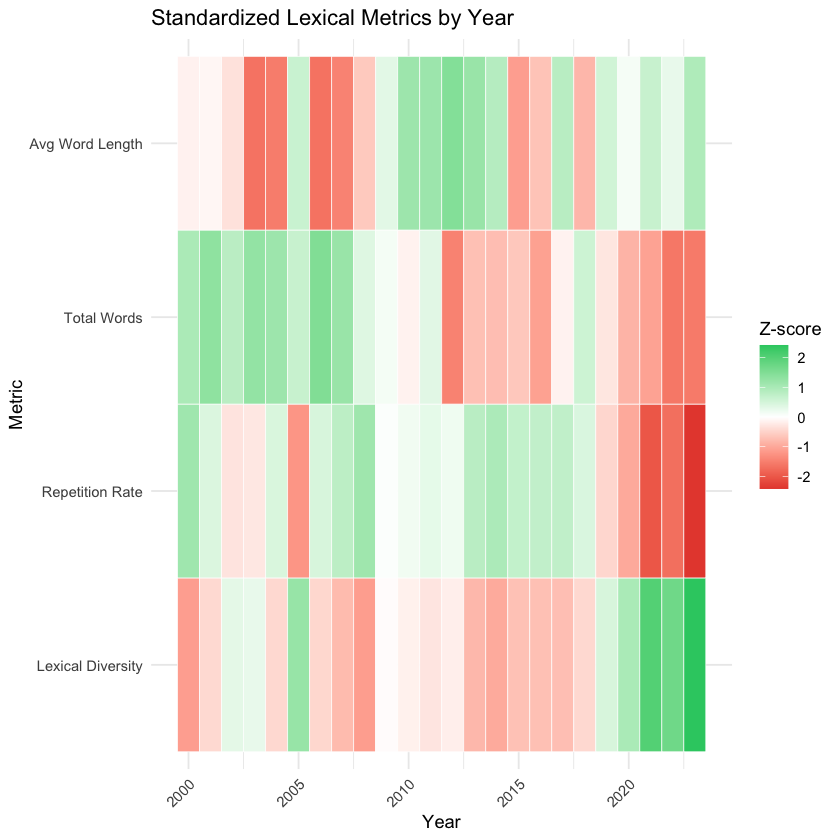

In [22]:
yearly_changes <- yearly_rankings_ordered %>%
  filter(!is.na(yoy_change)) %>%
  mutate(
    change_type = ifelse(yoy_change > 0, "Increase", "Decrease"),
    change_label = paste0(year - 1, " to ", year)
  )

p1 <- ggplot(yearly_changes, aes(x = year, y = yoy_change * 100, fill = change_type)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Increase" = "#2ECC71", "Decrease" = "#E74C3C")) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black", size = 0.5) +
  labs(title = "Year-over-Year Changes in Lexical Diversity",
       x = "Year", 
       y = "Change (percentage points)",
       fill = "Change Direction") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom")

print(p1)

top_increases <- yearly_changes %>% 
  arrange(desc(yoy_change)) %>% 
  head(5) %>%
  select(change_label, yoy_change, yoy_pct_change) %>%
  mutate(
    yoy_change = round(yoy_change, 4),
    yoy_pct_change = round(yoy_pct_change, 2)
  )

top_decreases <- yearly_changes %>% 
  arrange(yoy_change) %>% 
  head(5) %>%
  select(change_label, yoy_change, yoy_pct_change) %>%
  mutate(
    yoy_change = round(yoy_change, 4),
    yoy_pct_change = round(yoy_pct_change, 2)
  )

cat("\nTop 5 increases:\n")
print(top_increases)
cat("\nTop 5 decreases:\n")
print(top_decreases)

heatmap_data <- yearly_rankings %>%
  arrange(year) %>%
  select(year, avg_lexical_diversity, avg_repetition, avg_word_length, avg_total_words) %>%
  mutate(
    avg_lexical_diversity = scale(avg_lexical_diversity),
    avg_repetition = scale(avg_repetition),
    avg_word_length = scale(avg_word_length),
    avg_total_words = scale(avg_total_words)
  ) %>%
  pivot_longer(cols = -year, names_to = "metric", values_to = "value")

p2 <- ggplot(heatmap_data, aes(x = year, y = metric, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "#E74C3C", mid = "white", high = "#2ECC71", 
                       midpoint = 0, name = "Z-score") +
  labs(title = "Standardized Lexical Metrics by Year",
       x = "Year", 
       y = "Metric") +
  scale_y_discrete(labels = c(
    "avg_lexical_diversity" = "Lexical Diversity",
    "avg_repetition" = "Repetition Rate",
    "avg_word_length" = "Avg Word Length",
    "avg_total_words" = "Total Words"
  )) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p2)

`geom_smooth()` using formula = 'y ~ x'



Top 5 most diverse years:
# A tibble: 5 x 5
   rank  year avg_lexical_diversity avg_repetition num_songs
  <int> <int>                 <dbl>          <dbl>     <int>
1     1  2023                 0.367          0.633       133
2     2  2021                 0.360          0.640       150
3     3  2022                 0.354          0.646       142
4     4  2005                 0.346          0.654       140
5     5  2020                 0.341          0.659       145

Bottom 5 least diverse years:
# A tibble: 5 x 5
   rank  year avg_lexical_diversity avg_repetition num_songs
  <int> <int>                 <dbl>          <dbl>     <int>
1    24  2008                 0.303          0.697       139
2    23  2000                 0.303          0.697       115
3    22  2014                 0.306          0.694       149
4    21  2013                 0.309          0.691       141
5    20  2007                 0.310          0.690       142


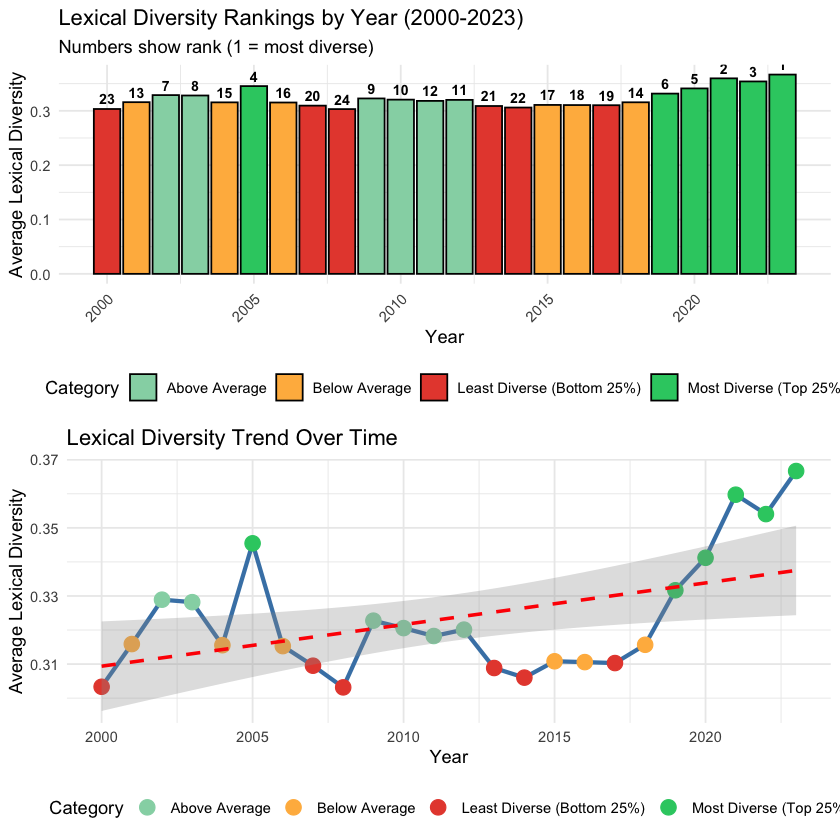

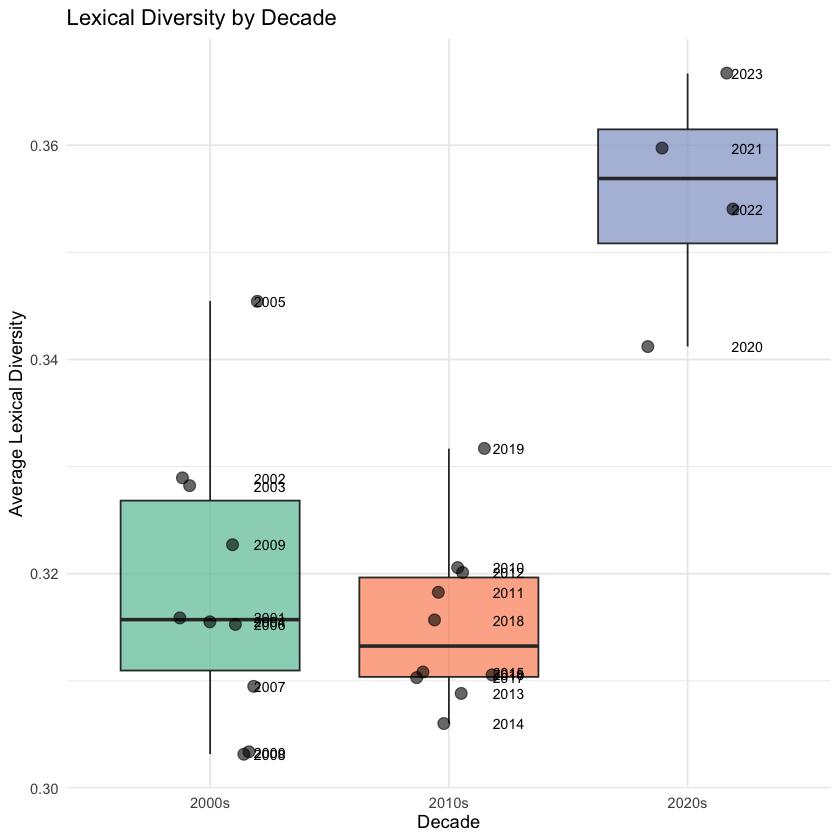

In [23]:
yearly_rankings_viz <- yearly_rankings %>% arrange(year)

p1 <- ggplot(yearly_rankings_viz, aes(x = year, y = avg_lexical_diversity, fill = diversity_category)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c(
    "Most Diverse (Top 25%)" = "#2ECC71",
    "Above Average" = "#95D5B2",
    "Below Average" = "#FFB84D",
    "Least Diverse (Bottom 25%)" = "#E74C3C"
  )) +
  geom_text(aes(label = rank), vjust = -0.5, size = 3, fontface = "bold") +
  labs(title = "Lexical Diversity Rankings by Year (2000-2023)",
       subtitle = "Numbers show rank (1 = most diverse)",
       x = "Year", 
       y = "Average Lexical Diversity",
       fill = "Category") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom")

p2 <- ggplot(yearly_rankings_viz, aes(x = year, y = avg_lexical_diversity)) +
  geom_line(size = 1.2, color = "steelblue") +
  geom_point(aes(color = diversity_category), size = 4) +
  scale_color_manual(values = c(
    "Most Diverse (Top 25%)" = "#2ECC71",
    "Above Average" = "#95D5B2",
    "Below Average" = "#FFB84D",
    "Least Diverse (Bottom 25%)" = "#E74C3C"
  )) +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed", alpha = 0.3) +
  labs(title = "Lexical Diversity Trend Over Time",
       x = "Year", 
       y = "Average Lexical Diversity",
       color = "Category") +
  theme_minimal() +
  theme(legend.position = "bottom")

grid.arrange(p1, p2, nrow = 2)

top_5 <- yearly_rankings %>% arrange(rank) %>% head(5)
bottom_5 <- yearly_rankings %>% arrange(desc(rank)) %>% head(5)

cat("\nTop 5 most diverse years:\n")
print(top_5 %>% 
  select(rank, year, avg_lexical_diversity, avg_repetition, num_songs) %>%
  mutate(
    avg_lexical_diversity = round(avg_lexical_diversity, 4),
    avg_repetition = round(avg_repetition, 4)
  ))

cat("\nBottom 5 least diverse years:\n")
print(bottom_5 %>% 
  select(rank, year, avg_lexical_diversity, avg_repetition, num_songs) %>%
  mutate(
    avg_lexical_diversity = round(avg_lexical_diversity, 4),
    avg_repetition = round(avg_repetition, 4)
  ))

p3 <- ggplot(yearly_rankings_viz, aes(x = decade, y = avg_lexical_diversity, fill = decade)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, size = 3, alpha = 0.6) +
  geom_text(aes(label = year), nudge_x = 0.25, size = 3) +
  scale_fill_brewer(palette = "Set2") +
  labs(title = "Lexical Diversity by Decade",
       x = "Decade", 
       y = "Average Lexical Diversity") +
  theme_minimal() +
  theme(legend.position = "none")

print(p3)

---
## Summary

Analysis of Billboard Top 100 songs (2000-2023) focused on lyrical characteristics.

**Analyses:**
1. Word frequency
2. Lexical complexity metrics (diversity & density)
3. Lyrics vs chart performance  
4. Temporal trends
5. Year-by-year rankings
6. Extreme examples
7. Audio features

**Key Metrics:**
- **Lexical Diversity**: Unique words / total words (vocabulary variety)
- **Lexical Density**: Content words / total words (information richness)

# Year-by-year rankings table and visualizations appear in the code cells above (after cell 26)

In [24]:
# Calculate yearly rankings by lexical diversity
yearly_rankings <- lyrics_metrics %>%
  group_by(year) %>%
  summarise(
    avg_lexical_diversity = mean(lexical_diversity, na.rm = TRUE),
    median_lexical_diversity = median(lexical_diversity, na.rm = TRUE),
    avg_repetition = mean(repetition_rate, na.rm = TRUE),
    avg_word_length = mean(avg_word_length, na.rm = TRUE),
    avg_total_words = mean(total_words, na.rm = TRUE),
    num_songs = n(),
    .groups = "drop"
  ) %>%
  arrange(desc(avg_lexical_diversity)) %>%
  mutate(
    rank = row_number(),
    decade = paste0(floor(year / 10) * 10, "s"),
    diversity_category = case_when(
      rank <= 6 ~ "Most Diverse (Top 25%)",
      rank <= 12 ~ "Above Average",
      rank <= 18 ~ "Below Average",
      TRUE ~ "Least Diverse (Bottom 25%)"
    )
  )

cat("Complete Year-by-Year Rankings (by Lexical Diversity):\n")
print(yearly_rankings %>%
  select(rank, year, avg_lexical_diversity, avg_repetition, num_songs) %>%
  mutate(
    avg_lexical_diversity = round(avg_lexical_diversity, 4),
    avg_repetition = round(avg_repetition, 4)
  ), n = Inf)

# Calculate year-over-year changes
yearly_rankings_ordered <- yearly_rankings %>%
  arrange(year) %>%
  mutate(
    yoy_change = avg_lexical_diversity - lag(avg_lexical_diversity),
    yoy_pct_change = (yoy_change / lag(avg_lexical_diversity)) * 100
  )

cat("\n✓ yearly_rankings and yearly_rankings_ordered created\n")

Complete Year-by-Year Rankings (by Lexical Diversity):
# A tibble: 24 x 5
    rank  year avg_lexical_diversity avg_repetition num_songs
   <int> <int>                 <dbl>          <dbl>     <int>
 1     1  2023                 0.367          0.633       133
 2     2  2021                 0.360          0.640       150
 3     3  2022                 0.354          0.646       142
 4     4  2005                 0.346          0.654       140
 5     5  2020                 0.341          0.659       145
 6     6  2019                 0.332          0.668       146
 7     7  2002                 0.329          0.671       134
 8     8  2003                 0.328          0.672       142
 9     9  2009                 0.323          0.677       130
10    10  2010                 0.321          0.679       147
11    11  2012                 0.320          0.680       131
12    12  2011                 0.318          0.682       148
13    13  2001                 0.316          0.684       

### 2.6 Extreme Examples

In [25]:
most_rep <- lyrics_metrics %>%
  arrange(desc(repetition_rate)) %>%
  select(song, band_singer, year, ranking, repetition_rate, lexical_diversity) %>%
  head(10)

most_div <- lyrics_metrics %>%
  arrange(desc(lexical_diversity)) %>%
  select(song, band_singer, year, ranking, lexical_diversity, repetition_rate) %>%
  head(10)

cat("Most repetitive songs:\n")
print(most_rep)

cat("\nMost diverse songs:\n")
print(most_div)

Most repetitive songs:
                    song       band_singer year ranking repetition_rate
1               Watch Me    Silent\303\263 2015       8       0.9294118
2               Watch Me    Silent\303\263 2016      88       0.9294118
3              Get Lucky         Daft Punk 2013      14       0.9030544
4              Get Lucky Pharrell Williams 2013      14       0.9030544
5                   Gold            Kiiara 2016      52       0.8983607
6  ILY (I Love You Baby)         Surf Mesa 2020      95       0.8903509
7       Blue (Da Ba Dee)         Eiffel 65 2000      49       0.8735441
8      Turn Up the Music       Chris Brown 2012      84       0.8695652
9           Harlem Shake            Baauer 2013       4       0.8600000
10            Thong Song      Sisq\303\263 2000      14       0.8568156
   lexical_diversity
1         0.07058824
2         0.07058824
3         0.09694555
4         0.09694555
5         0.10163934
6         0.10964912
7         0.12645591
8         0.13043

---
## Part 3: Audio Features

In [26]:
df_audio <- df %>% filter(!is.na(danceability))

audio_summary <- df_audio %>%
  summarise(
    Danceability = round(mean(danceability), 2),
    Energy = round(mean(energy), 2),
    Valence = round(mean(valence), 2),
    Tempo = round(mean(tempo), 1),
    Acousticness = round(mean(acousticness), 2)
  )

print(audio_summary)

  Danceability Energy Valence Tempo Acousticness
1         0.67   0.69     0.6 116.6         0.16


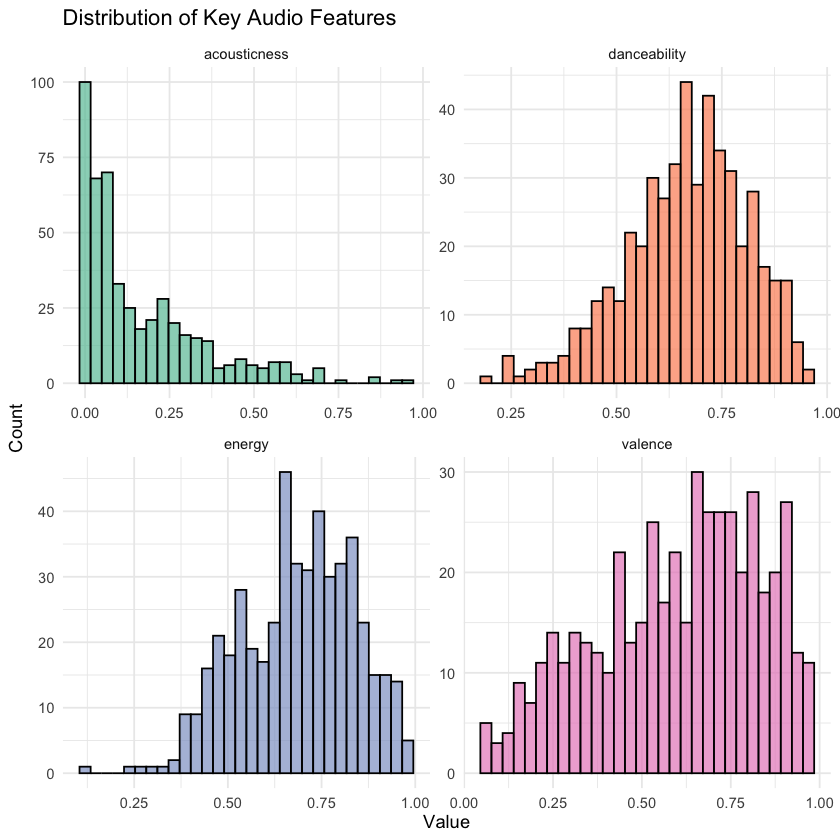

In [27]:
# Simple visualization of key audio features
audio_long <- df_audio %>%
  select(danceability, energy, valence, acousticness) %>%
  pivot_longer(everything(), names_to = "feature", values_to = "value")

ggplot(audio_long, aes(x = value, fill = feature)) +
  geom_histogram(bins = 30, alpha = 0.7, color = "black") +
  facet_wrap(~ feature, scales = "free") +
  scale_fill_brewer(palette = "Set2") +
  labs(title = "Distribution of Key Audio Features",
       x = "Value", y = "Count") +
  theme_minimal() +
  theme(legend.position = "none")

---
## Summary

Analysis of Billboard Top 100 songs (2000-2023) focused on lyrical characteristics.

**Analyses:**
1. Word frequency
2. Lexical complexity metrics
3. Lyrics vs chart performance  
4. Temporal trends
5. Year-by-year rankings
6. Extreme examples
7. Audio features